# Aproximación de ataque a caja negra por modelo sustituto [1]

## Se debe ejecutar, ya que si no no descarga los paquetes, además, se debe cargar el archivo **imagenet_class_index.json** disponible en el repositorio. Créditos a Andrés González por crear la base de este *notebook*

In [ ]:
!pip install -U --no-cache-dir gdown --pre

In [ ]:
# Descarga del modelo de caja negra, los labels y la clase BlackBoxCNN

!gdown https://drive.google.com/uc?id=1bv6uXZVnGTWKp8OFG9Vl_BpW9cnLbVzQ
!gdown https://drive.google.com/uc?id=1MU-ILaGaIKRR1RLEw9oX7oaJl_fcwa01
!gdown https://drive.google.com/uc?id=1lKuIgGQx86beN4hzkM0fFkf5FPe6rq1y

In [ ]:
categories_path = "/content/classes.txt"
blackbox_path = "/content/BlackBoxCNN"

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, Subset, Sampler
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision import datasets
from PIL import Image

import os
from tqdm import tqdm

from blackboxcnn import BlackBoxCNN

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Sampler para seleccionar clases en particular
class ClassIDSampler(Sampler):
    def __init__(self, dataset_labels, class_id):
      self.mask = torch.tensor([idx in class_id for idx in dataset_labels])

    def __iter__(self):
      masked_indices = torch.nonzero(self.mask)
      masked_indices = masked_indices[torch.randperm(masked_indices.shape[0])]
      return (idx for idx in masked_indices)

    def __len__(self):
      return len(self.mask)

## Carga de datos

### Preprocesamiento

In [ ]:
# Pre-procesamiento requerido por la caja negra
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Datasets de Pytorch

In [ ]:
# Si ya tienen descargados algunos datasets en colab --> download=False 
# para no volver a descargarlos. Si es primera vez que cargan un dataset
# --> download=True

test_data = datasets.CIFAR10(
          root="data",
          train=False,
          download=True,
          transform=preprocess
      )

# test_data = datasets.CIFAR100(
#           root="data",
#           train=False,
#           download=False,
#           transform=preprocess
#       )


# test_data = datasets.STL10(
#           root="data",
#           split="test",
#           download=False,
#           transform=preprocess
#       )


# Sampler por si se quiere elegir un subset con determinadas clases
# Revisar que atributo contiene los labels, puede ser labels, targets u otros
# id_sampler = ClassIDSampler(test_data.targets, [4,6,7])

test_loader = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)#, sampler=id_sampler) # Si eligen usar el sampler, colocar 
                                                                                                                      # shuffle=True y descomentar el sampler

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


### Imágenes "sueltas"

In [ ]:
# Descarga de imagen de ejemplo

!wget -O dog.jpg https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=1.00xw:0.669xh;0,0.190xh&resize=1200:*

In [ ]:
img_path = "/content/dog.jpg" # Esta es una imagen de ejemplo que saque de internet

test_image = Image.open(img_path)

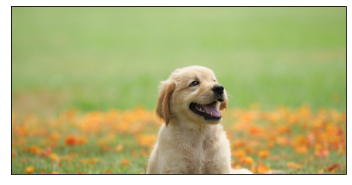

In [ ]:
plt.imshow(test_image)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
test_image = preprocess(test_image)
input_batch = test_image.unsqueeze(0)
test_loader_single = DataLoader(input_batch , num_workers=2, pin_memory=True)

## Salida de caja negra

In [ ]:
# La clase BlackBoxCNN representa a la caja negra, con un modelo pre-entrenado con algún
# dataset en particular. Para generar una instancia se deben pasar la ruta del archivo
# con el modelo descargado, junto con los labels del modelo

blackbox = BlackBoxCNN(blackbox_path, categories_path)

In [ ]:
# La clase BlackBoxCNN contiene solo un método correspondiente a predict. El cual
# retorna una lista con el top N de mejores probabilidades de un dato a pertenecer
# a alguna de las clases de la caja negra.

# Este método tiene los siguientes parámetros:
#           - input_loader: El DataLoader de pytorch con los datos que
#                           utilizarán.
#           - n: Correponde a la cantidad de outputs que quieren observar de cada
#                 dato clasificado. Por default es 5. En otras palabras, selecciona
#               el top n de mejores probabilidades.
#           - threshold: Corresponde al límite de probabilidad para que se observen
#                         las predicciones de un dato en la salida. Ej:
#                       threshold=0.9, solo se considererán aquellas salidas cuya
#                       probabilidad más alta es mayor o igual a 0.9.
#           - label: Solo en caso de ingresar un DataLoader con una sola imagen,
#                     Se coloca el label de preferencia.

probabilities = blackbox.predict(test_loader, n=5, threshold=0.9)
probabilities_single = blackbox.predict(test_loader_single, label=["dog"], n=5)

In [ ]:
probabilities_single

[[('dog', 'golden retriever', 0.7903026938438416),
  ('dog', 'Labrador retriever', 0.08038263767957687),
  ('dog', 'Brittany spaniel', 0.05240189656615257),
  ('dog', 'flat-coated retriever', 0.009937357157468796),
  ('dog', 'clumber', 0.00669160345569253)]]

## Prueba con imagen de camión

In [ ]:
!wget -O truck.jpg https://thumbs.dreamstime.com/b/american-style-truck-freeway-pulling-load-transportation-theme-road-cars-174771780.jpg?crop=1.00xw:0.669xh;0,0.190xh&resize=1200:*

In [ ]:
truck_path = "/content/truck.jpg"
truck_image = Image.open(truck_path)

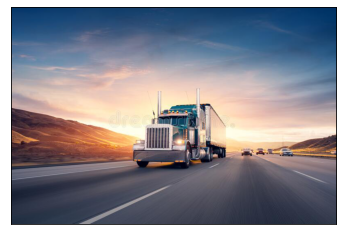

In [ ]:
plt.imshow(truck_image)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
truck_image = preprocess(truck_image)
input_batch = truck_image.unsqueeze(0)
test_loader_single = DataLoader(input_batch , num_workers=2, pin_memory=True)

In [ ]:
# Se observan las predicciones para la imagen del camion
probabilities = blackbox.predict(test_loader, n=5, threshold=0.9)
probabilities_single = blackbox.predict(test_loader_single, label=["truck"], n=5)

In [ ]:
probabilities
# Labels: a priori no se sabe qué dataset se utiliza, pero se pueden observar
# los labels que le asigna a las predicciones

In [ ]:
# Distribución de probabilidad
probabilities_single

[[('truck', 'trailer truck', 0.942188024520874),
  ('truck', 'garbage truck', 0.008855072781443596),
  ('truck', 'tow truck', 0.006898520980030298),
  ('truck', 'golfcart', 0.005914674606174231),
  ('truck', 'moving van', 0.005676566157490015)]]

## Modelo pre-entrenado: ResNet - 50

In [ ]:
# Dataset de entrenamiento: ImageNet
from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
model = resnet50(pretrained=True)

In [ ]:
# Modo de evaluación
model.eval()
model.to(device)

In [ ]:
truck_path = "/content/truck.jpg"
truck_image = Image.open(truck_path)

In [ ]:
# Pre-procesar la imagen
truck_image = preprocess(truck_image)
input_batch2 = truck_image.unsqueeze(0)

In [ ]:
output1 = model(input_batch2)

In [ ]:
# Se determina la distribución de probabilidad
import torch.nn.functional as f
prob = f.softmax(model(input_batch2)[0],dim=0)
topN_prob,topN_catid = torch.topk(prob,5)

In [ ]:
# Label con que predice
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[output1.max(dim=1)[1].item()])

trailer_truck


In [ ]:
#Distribución de probabilidad
topN_prob

tensor([0.9422, 0.0089, 0.0069, 0.0059, 0.0057], grad_fn=<TopkBackward0>)

In [ ]:
# Labels
topN_catid

tensor([867, 569, 864, 575, 675])

In [ ]:
# Se leen del archivo de clases
for cl in topN_catid:
  print((imagenet_classes[cl.item()]))

trailer_truck
garbage_truck
tow_truck
golfcart
moving_van


## Distribución de probabilidad con imagen de prueba

In [ ]:
img_path = "/content/dog.jpg"
test_image = Image.open(img_path)
test_image = preprocess(test_image)
input_batch = test_image.unsqueeze(0)

output2 = model(input_batch)

In [ ]:
import torch.nn.functional as nnf

In [ ]:
prob2 = nnf.softmax(output2[0],dim=0)
topN_prob2,topN_catid2 = torch.topk(prob2,5)

In [ ]:
test_loader_single = DataLoader(input_batch , num_workers=2, pin_memory=True)

In [ ]:
print(imagenet_classes[output2.max(dim=1)[1].item()])

golden_retriever


In [ ]:
# Top-5 probabilidades
topN_prob2

tensor([0.7903, 0.0804, 0.0524, 0.0099, 0.0067], grad_fn=<TopkBackward0>)

In [ ]:
# Top-5 redicciones de la red
for cl in topN_catid2:
  print((imagenet_classes[cl.item()]))

golden_retriever
Labrador_retriever
Brittany_spaniel
flat-coated_retriever
clumber


### Ataque adversario: es posible cambiar el valor de $\varepsilon$ para PGD, con este valor se supera la robustez del modelo caja negra

In [ ]:
import torch.optim as optim
from torch import nn

# Definicion ataque PGD

def pgd(modelo, X, y, epsilon, alpha, num_iter):
    """ Construct PGD adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(modelo(X + delta), y)
        loss.backward(retain_graph=True)
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach(), loss.item()

In [ ]:
# PGD con 100 iteraciones, epsilon = 0.3, alpha = 0.01
y = model(input_batch)
delta_new, l_item = pgd(model,input_batch,y,0.3,0.01,100)

In [ ]:
# Top-5 de predicción
prob3 = nnf.softmax(model(input_batch+delta_new)[0],dim=0)
topN_prob3,topN_catid3 = torch.topk(prob3,5)

In [ ]:
# Probabilidades ej.adversario
topN_prob3

tensor([9.9994e-01, 4.7051e-05, 5.3977e-06, 1.0492e-06, 1.0335e-06],
       grad_fn=<TopkBackward0>)

In [ ]:
# Labels asignados
for cl in topN_catid3:
  print((imagenet_classes[cl.item()]))

spiny_lobster
common_iguana
whiptail
alligator_lizard
eel


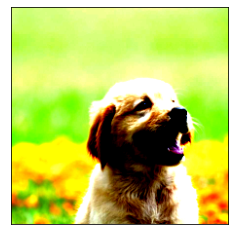

In [ ]:
# Imagen del perro en dataset (normalizado)
img_original = (input_batch)[0]
plt.xticks([])
plt.yticks([])
plt.imshow(img_original.detach().numpy().transpose(1,2,0))
plt.savefig('perro_normal.jpg')
plt.show()

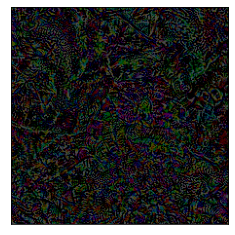

In [ ]:
error = (delta_new)[0]
plt.xticks([])
plt.yticks([])
plt.imshow(error.detach().numpy().transpose(1,2,0))
plt.savefig('ruido.jpg')
plt.show()

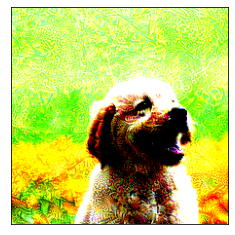

In [ ]:
# 
img = (input_batch+delta_new)[0]
plt.xticks([])
plt.yticks([])
plt.imshow(img.detach().numpy().transpose(1,2,0))
plt.savefig('perro_ataque.jpg')
plt.show()

In [ ]:
import torchvision.transforms
ataque = Image.open('/content/perro_ataque.jpg')
tf =  torchvision.transforms.ToTensor()
ataque = tf(ataque)
inp_batch_att = ataque.unsqueeze(0)
attack_loader_single = DataLoader(img , num_workers=2, pin_memory=True)

In [ ]:
# Modelo caja negra (ALTERNATIVA AL CÓDIGO, YA QUE HUBO
# PROBLEMA PARA HACER EL DATALOADER QUE SE ENTREGABA AL ARCHIVO)
black_box = torch.load(blackbox_path)
out = black_box(inp_batch_att)
prob_attack = nnf.softmax(out[0],dim=0)

In [ ]:
topN_prob, topN_catid = torch.topk(prob_attack, 5)

In [ ]:
with open(categories_path, "r") as f:
      categories = [s.strip() for s in f.readlines()]

In [ ]:
for cat in topN_catid:
  print(categories[cat.item()]) 

envelope
Indian elephant
web site
bison
Arabian camel


In [ ]:
# Probabilidades
topN_prob

tensor([0.0695, 0.0655, 0.0561, 0.0554, 0.0352], grad_fn=<TopkBackward0>)

## Modelo pre-entrenado VGG-16

In [ ]:
from torchvision.models import vgg16,VGG16_Weights

In [ ]:
model2 = vgg16(pretrained=True)
model2.to(device)

### Distribución de probabilidad con imágenes de camión y perro

In [ ]:
# Perro
output3 = model2(input_batch)

prob_v1 = nnf.softmax(output3[0],dim=0)

In [ ]:
# Top-5
topN_probv, topN_catidv = torch.topk(prob_v1, 5)

In [ ]:
topN_probv

tensor([0.8176, 0.1125, 0.0221, 0.0062, 0.0058], grad_fn=<TopkBackward0>)

In [ ]:
for cl in topN_catidv:
  print(imagenet_classes[cl.item()])

golden_retriever
Labrador_retriever
Brittany_spaniel
clumber
cocker_spaniel


In [ ]:
# Camión
output4 = model2(input_batch2)

prob_v2 = nnf.softmax(output4[0],dim=0)

In [ ]:
# Top-5
topN_probv2, topN_catidv2 = torch.topk(prob_v2,5)

In [ ]:
topN_probv2

tensor([0.9565, 0.0178, 0.0167, 0.0039, 0.0032], grad_fn=<TopkBackward0>)

In [ ]:
for cat in topN_catidv2:
  print(imagenet_classes[cat.item()])

trailer_truck
garbage_truck
snowplow
moving_van
tow_truck


### Ejemplo adversario

In [ ]:
# PGD con 100 iteraciones, epsilon = 0.3, alpha = 0.01
y = model2(input_batch)
delta_new2, l_item2 = pgd(model2,input_batch,y,0.3,0.01,100)

In [ ]:
# Top-5 de predicción
probv3 = nnf.softmax(model2(input_batch+delta_new2)[0],dim=0)
topN_probv3,topN_catidv3 = torch.topk(probv3,5)

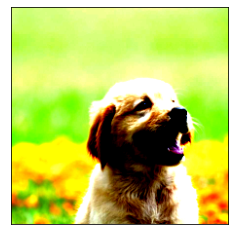

In [ ]:
# Imagen del perro en dataset (normalizado)
img_original = (input_batch)[0]
plt.xticks([])
plt.yticks([])
plt.imshow(img_original.detach().numpy().transpose(1,2,0))
plt.savefig('perro_normal.jpg')
plt.show()

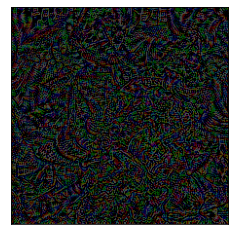

In [ ]:
error = (delta_new2)[0]
plt.xticks([])
plt.yticks([])
plt.imshow(error.detach().numpy().transpose(1,2,0))
plt.savefig('ruido2.jpg')
plt.show()

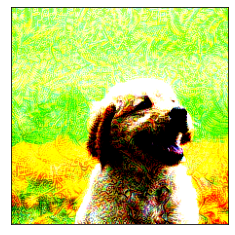

In [ ]:
# 
img = (input_batch+delta_new2)[0]
plt.xticks([])
plt.yticks([])
plt.imshow(img.detach().numpy().transpose(1,2,0))
plt.savefig('perro_ataque2.jpg')
plt.show()

In [ ]:
ataque2 = Image.open('/content/perro_ataque2.jpg')
tf =  torchvision.transforms.ToTensor()
ataque2 = tf(ataque2)
inp_batch_att2 = ataque2.unsqueeze(0)
attack_loader_single2 = DataLoader(inp_batch_att2 , num_workers=2, pin_memory=True)

In [ ]:
out2 = black_box(inp_batch_att2)
prob_attack2 = nnf.softmax(out2[0],dim=0)

In [ ]:
topN_prob_attack2, topN_cat_attack2 = torch.topk(prob_attack2,5)

In [ ]:
topN_prob_attack2

tensor([0.1945, 0.0668, 0.0234, 0.0181, 0.0155], grad_fn=<TopkBackward0>)

In [ ]:
for cl in topN_cat_attack2:
  print(categories[cl.item()])

envelope
web site
pug
book jacket
Arabian camel


## Referencias:
### [1] Y. Liu, C. Liu, D. Song and X. Chen. Delving into transferable adversarial examples and black-box attacks. arXiv:1611.02770v3. 2017 